# Bus Parameter Validation

In this notebook we validate the electric bus parameters we'll input to FASTSim. This must be done before we can trust our FASTSim CDMX bus route simulation outputs.

We don't have a lot of great options to validate our simulation output against experimental results, so we'll compare our simulation results to the simulation results from the 2021 LOGIOS study of electrifying bus routes in Mexicali.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
from fastsim import simdrive, vehicle, cycle
import utils
utils.run_tests()

## The hybrid Yutong/Logios Bus Parameters

In [3]:
# Highlight the parameter differences between the yutong bus parameters and the newer 
# parameters we're using to approximate the buses used by LOGIOS in their report.
vehicles_df = pd.read_csv(Path('./bus.csv'))
yutong = vehicles_df.iloc[0]
logios = vehicles_df.iloc[1]
diff_cols = []
for i in range(len(yutong)):
    if (yutong[i] != logios[i]) and not pd.isnull(yutong[i]):
        diff_cols.append(yutong.index[i])
vehicles_df.filter(diff_cols)

,Selection,Scenario name,frontalAreaM2,gliderKg,cargoKg,maxMotorKw,maxEssKwh,minSoc,maxSoc,auxKw
0,1,Yutong,7.46,10000,5000,350,295,10%,90%,10
1,2,LOGIOS/Yutong,8.50,14050,3600,300,325,0%,100%,0


In [4]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()

## The LOGIOS drive cycles

We'll use FASTSim to simulate the power requirements of multiple LOGIOS-recorded drive cycles. 

In [5]:
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
routes_and_days = {
    'AB03': {
        # Days when drive cycle data was collected for this route
        'days': ['0520', '0521', '0527', '0531'],
        
        # LOGIOS-predicted range along this route from 100% to 0% SOC.
        # Extracted from LOGIOS 'Energy Available' graph in deliverable 4 report. e.g. Fig. 4.
        'rangeKm': 221.18,
    },
    'TC08': {
        'days': ['0525'], 
        'rangeKm': 245.32,
    },
    'ATE09': {
        'days': ['0520', '0521', '0525', '0527'],
        'rangeKm': 227.11
    }
}

# Simulate all distinct (route,day) drive cycles and store results
results = {}
for route_name in routes_and_days.keys():
    route = routes_and_days[route_name]
    for day in route['days']:
        print(f'Processing route {route_name}, day {day}...')
        drive_cycle_path = Path(INPUT_PATH) / route_name / day
        output = utils.run_fastsim(drive_cycle_path, bus_jit)
        output['fastsim_range'] = output['rangeKm']
        output['logios_range'] = route['rangeKm']
        results[f'{route_name}/{day}'] = output

Processing route AB03, day 0520...
Time to run simulation: 3.57e+01 s
Processing route AB03, day 0521...
Time to run simulation: 3.03e+00 s
Processing route AB03, day 0527...
Time to run simulation: 2.72e+00 s
Processing route AB03, day 0531...
Time to run simulation: 4.35e+00 s
Processing route TC08, day 0525...
Time to run simulation: 2.89e+00 s
Processing route ATE09, day 0520...
Time to run simulation: 2.88e+00 s
Processing route ATE09, day 0521...
Time to run simulation: 2.64e+00 s
Processing route ATE09, day 0525...
Time to run simulation: 2.25e+00 s
Processing route ATE09, day 0527...
Time to run simulation: 2.58e+00 s


Note, the *"Warning: There is a problem with conservation of energy."* error message occurs when the simulation continues past the point when the battery runs out of juice. This pretty much always happens, since these drive cycles are longer than an electric battery could actually handle without recharge. It still gives us the central output value we're looking for: The range (in km) the bus can travel before the battery's S.O.C. hits 0%.

## Comparing FASTSim's predicted driving ranges against LOGIOS'

For each (route, day)-defined drive cycle, let's compare the ratio $\frac{\text{FASTSim-predicted range}}{\text{LOGIOS-predicted range}}$


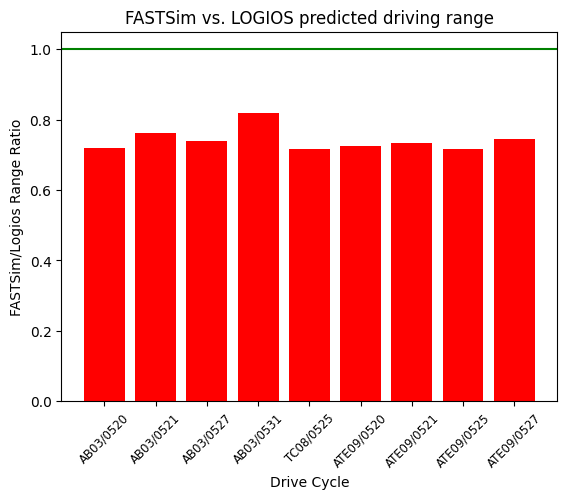

On average, of the 9 simulated drive cycles, FASTSim's simulated range is 74.2% of LOGIOS's


In [6]:
route_days = []
range_diffs = []
for drive_cycle in results.keys():
    route_days.append(drive_cycle)
    fastsim_range = results[drive_cycle]['fastsim_range']
    logios_range = results[drive_cycle]['logios_range']
    range_diffs.append(fastsim_range/logios_range)

plt.bar(route_days, height=range_diffs, color='red')
plt.title('FASTSim vs. LOGIOS predicted driving range')
plt.axhline(1.0, color='green')
plt.xlabel('Drive Cycle')
plt.ylabel('FASTSim/Logios Range Ratio')
plt.xticks(rotation=45, fontsize='small')
plt.show()

print(f'On average, of the {len(route_days)} simulated drive cycles, FASTSim\'s simulated range is {np.average(range_diffs)*100:.01f}% of LOGIOS\'s')

# [WIP] Detecting periods when the bus is stopped

TODO: Currently my naive stop detection suffers from a lot of fragmentation due to noise in the drive cycle data.

In [8]:
def detect_stops(df, time_range, epsilon = 1*10**-1):
    '''
    Return a list of (start, stop) tuples, each describing a start and stop time (inclusive) of an 
    extent of time when the vehicle was stopped.
    '''
    # Linear search, find contiguous segments of near-zero speed
    extents = []
    stopped = False
    curr_extent = [np.nan, np.nan]
    for i in time_range:
        speed = df.iloc[i]['speed']
        #print('speed', speed)
        if abs(speed) <= epsilon: # We are stopped at this time step
            if not stopped:
                #print(f'Starting extent. t:{i}, speed:{speed}')
                stopped = True
                curr_extent = [i,i]
            else:
                curr_extent[1] = i
        else: # We are moving at this timestep
            if not stopped:
                pass
            else:
                #print(f'Stopping extent. t:{i}, speed:{speed}')
                extents.append(tuple(curr_extent))
                curr_extent = [np.nan, np.nan]
                stopped = False
                
    # Filter out noise: Remove any extents of length less than 15 seconds
    extents = list(filter(lambda x: x[1]-x[0] >= 15, extents))
    # print('extents', extents)
    # print('lengths', list(map(lambda x: x[1]-x[0], extents)))
    return extents

assert False # TODO
# Try another approach
# Star

data = {
    "speed": [1,2,3,0,0,0,4,5,6],
}
df = pd.DataFrame(data)
time_range = range(0,9)
extents = detect_stops(df, time_range)

# [WIP] Visualizing extent detection for drive cycle AB03/0520

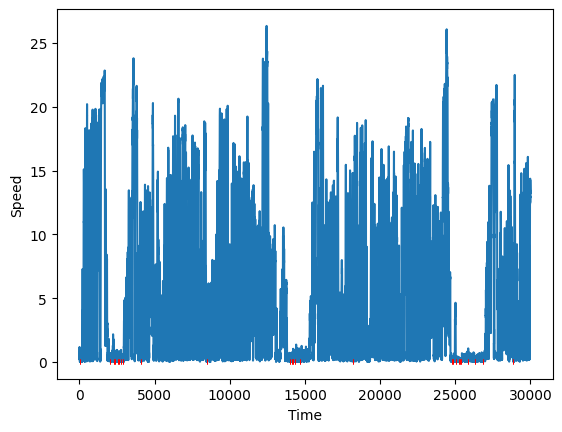

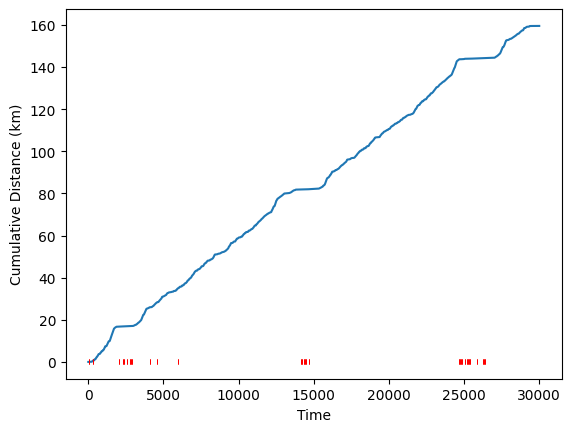

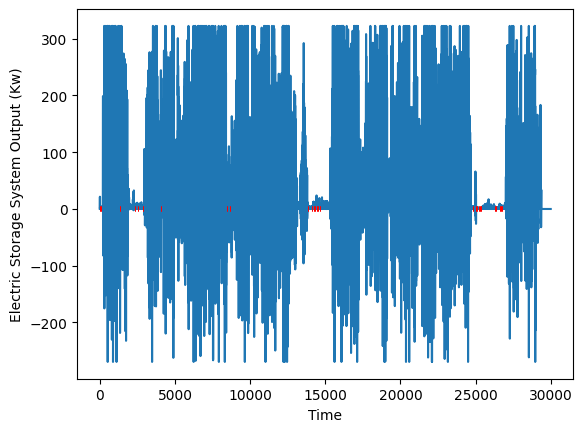

In [9]:
output = results['AB03/0520']
df = pd.DataFrame.from_dict(output)
time_range = range(0,30000)
df = df[time_range.start:time_range.stop]

extents = detect_stops(df, time_range, epsilon=0.3)

plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
for extent in extents:
    plt.hlines(0, extent[0], extent[1], color='red', linewidths=4)
plt.show()

plt.plot(df['time'],df['cumDistKm'])
for extent in extents:
    plt.hlines(0, extent[0], extent[1], color='red', linewidths=4)
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.show()

plt.plot(df['time'], df['essKwOutAch'])
for extent in extents:
    plt.hlines(0, extent[0], extent[1], color='red', linewidths=4)
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()       

# Visualizing FASTSim results for all routes

TODO: Do so for all routes, not just one

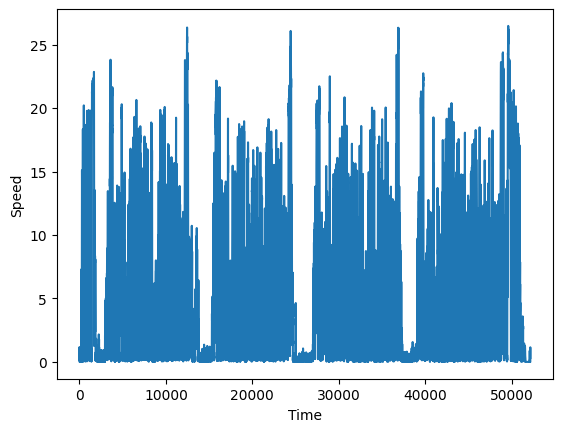

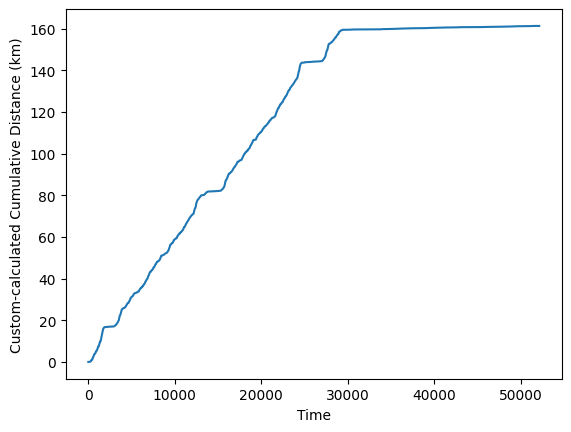

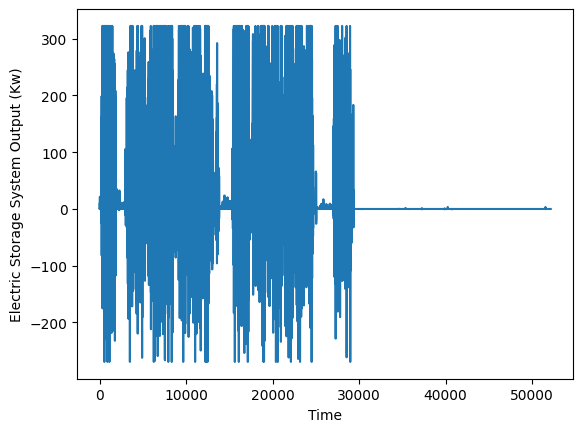

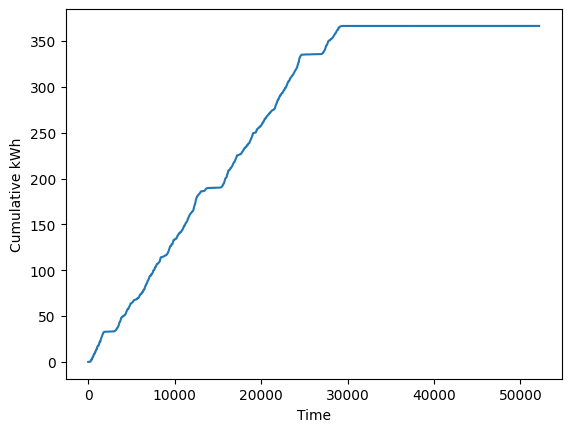

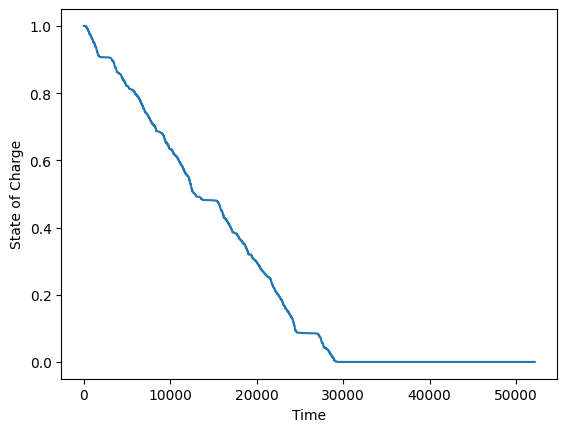

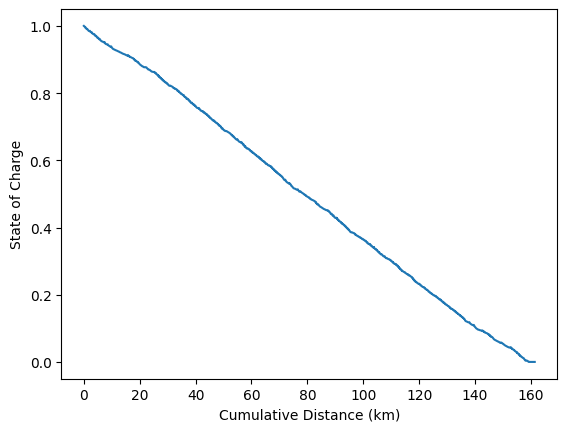

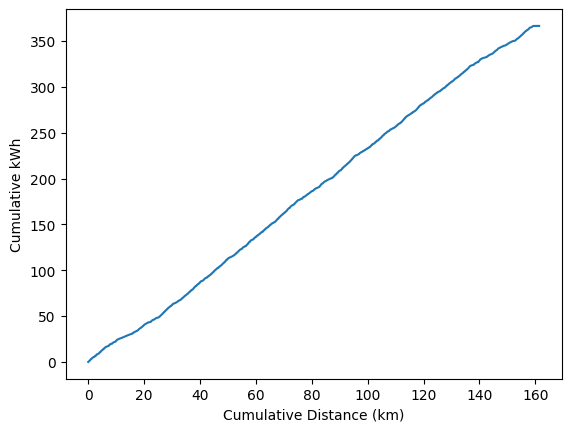

In [10]:
# TODO subplot this up: https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/

# Visualize
df = pd.DataFrame.from_dict(output)

# plt.rcParams['figure.figsize'] = [30, 20]

plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.show()

plt.plot(df['time'],df['cumDistKm'])
plt.xlabel('Time')
plt.ylabel('Custom-calculated Cumulative Distance (km)')
plt.show()

plt.plot(df['time'], df['essKwOutAch'])
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()

plt.plot(df['time'], df['cumKwh'])
plt.xlabel('Time')
plt.ylabel('Cumulative kWh')
plt.show()

plt.plot(df['time'],df['soc'])
plt.xlabel('Time')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'],df['soc'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'], df['cumKwh'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Cumulative kWh')
plt.show()

In [11]:
print('Simulation summary:')
print(f'Final S.O.C.: {output["final_soc"]*100:.2f} %')
print(f'Distance driven: {output["distance_mi"]:.2f} miles. {output["distance_mi"]*utils.km_per_mile:.2f} km')
print(f'Total time driven (if battery didn\'t run out): {df["time"].iloc[-1] * 1/3600:.2f} hours')
print(f'Total energy required: {df["cumKwh"].iloc[-1]:.2f} kWh')
# TODO: How can the cumulative kwh exceed the max capacity of the battery?

Simulation summary:
Final S.O.C.: 0.00 %
Distance driven: 100.29 miles. 161.41 km
Total time driven (if battery didn't run out): 14.49 hours
Total energy required: 366.52 kWh


# Exploring LOGIOS' Graphs
Exploring the relationship between 'discriminated consumption' and 'energy available' graphs for each route in LOGIOS' "Deliverable 4 Energy Consumption Projection" report.

## AB03: Discriminated Consumption (Fig. 2) vs Energy Available (Fig. 4)

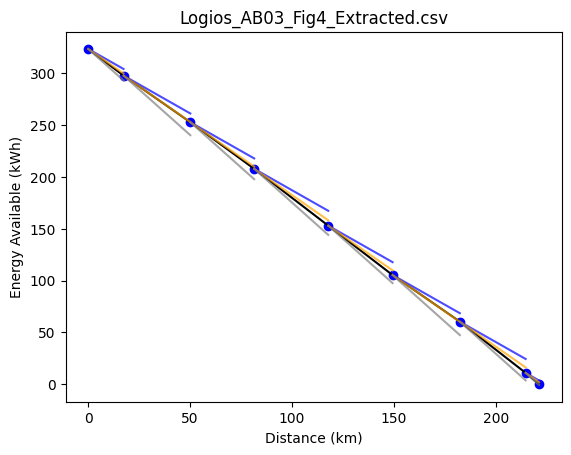

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   0.0 km.  dist: 17.3 km.  energy: -25.7 kWh
[Segment 2] start:  17.3 km.  dist: 32.8 km.  energy: -45.0 kWh
[Segment 3] start:  50.1 km.  dist: 31.3 km.  energy: -45.0 kWh
[Segment 4] start:  81.4 km.  dist: 36.3 km.  energy: -54.9 kWh
[Segment 5] start: 117.7 km.  dist: 31.6 km.  energy: -47.7 kWh
[Segment 6] start: 149.3 km.  dist: 33.0 km.  energy: -45.0 kWh
[Segment 7] start: 182.3 km.  dist: 32.3 km.  energy: -49.5 kWh
[Segment 8] start: 214.6 km.  dist: 6.6 km.  energy: -10.8 kWh


In [12]:
# Given an inital point x0,y0, line slope m, second x value x1, compute y1.
def y(x, m, x0, y0):
    return m*(x-x0) + y0

def compare_logios_graphs_for_route(disc_consump_file, energy_avail_file):
    DISC_CONSUMPT_DIR = '../Data/LOGIOS Data/Report 4 Extracts/Discriminated Consumption'
    df = pd.read_csv(Path(DISC_CONSUMPT_DIR) / disc_consump_file)
    # The energy consumption slopes (kWh/km) of the 3 discriminated consumptions rates
    # Baseline
    base_m = -df.y[0] / df.x[0]
    # Baseline + Passengers
    base_pass_m = -df.y[1] / df.x[1]
    # Baseline + Passengers + HVAC
    base_pass_hvac_m = -df.y[2] / df.x[2]

    # Graph the Energy Available graph (e.g. fig 4)
    ENERGY_AVAILABLE_DIR = '../Data/LOGIOS Data/Report 4 Extracts/Energy Available'
    df = pd.read_csv(Path(ENERGY_AVAILABLE_DIR) / energy_avail_file)
    plt.plot(df.x, df.y, color='black')
    plt.scatter(df.x, df.y, color='blue')

    # Overlay discriminated consumption rates
    # For each segment, show what the energy burn-down would be at the rates depicted in the
    # respective discriminated consumption graph (e.g. fig 2)
    for i in range(len(df)-1):
        # Base
        x0, y0 = df.x[i], df.y[i]
        x1 = df.x[i+1]
        plt.plot([x0, x1], [y0, y(x1, base_m, x0, y0)], color='blue', alpha=0.7)
        plt.plot([x0, x1], [y0, y(x1, base_pass_m, x0, y0)], color='orange', alpha=0.7)
        plt.plot([x0, x1], [y0, y(x1, base_pass_hvac_m, x0, y0)], color='gray', alpha=0.7)
        # TODO: Or should each segment's dx be 36, to capture ?

    plt.title(f'{energy_avail_file}')
    plt.xlabel(f'Distance (km)')
    plt.ylabel(f'Energy Available (kWh)')
    plt.show()

    print(f'Energy-Available Graph consumption rates per segment:')
    for i in range(1, len(df)):
        # Distance Travelled
        dx = df.x[i] - df.x[i-1]
        # Energy consumed
        de = df.y[i] - df.y[i-1]
        print(f"[Segment {i}] start: {df.x[i-1]:5.01f} km.  dist: {dx:3.01f} km.  energy: {de:5.01f} kWh")
        
disc_consump_file = 'Logios_AB03_Fig2_Extracted.csv'
energy_avail_file = 'Logios_AB03_Fig4_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

## TC08: Discriminated Consumption (Fig. 11) vs Energy Available (Fig. 13)

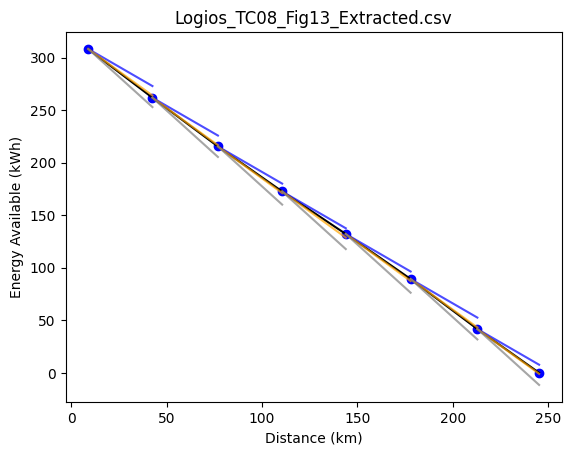

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   8.8 km.  dist: 33.7 km.  energy: -46.4 kWh
[Segment 2] start:  42.5 km.  dist: 34.3 km.  energy: -46.4 kWh
[Segment 3] start:  76.9 km.  dist: 33.7 km.  energy: -42.9 kWh
[Segment 4] start: 110.6 km.  dist: 33.4 km.  energy: -40.5 kWh
[Segment 5] start: 143.9 km.  dist: 34.0 km.  energy: -42.9 kWh
[Segment 6] start: 177.9 km.  dist: 35.0 km.  energy: -47.6 kWh
[Segment 7] start: 212.9 km.  dist: 32.4 km.  energy: -41.7 kWh


In [13]:
disc_consump_file = 'Logios_TC08_Fig11_Extracted.csv'
energy_avail_file = 'Logios_TC08_Fig13_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

## ATE09: Discriminated Consumption (Fig. 5) vs Energy Available (Fig. 7)

Note: Unlike the other routes, for ATE09 the discriminated consumption graph is presented as the whole day's data (instead of one segment). So the extracted energy burndown rates represent an average over the whole day, instead of the rate of one sampled segment as in the other routes.

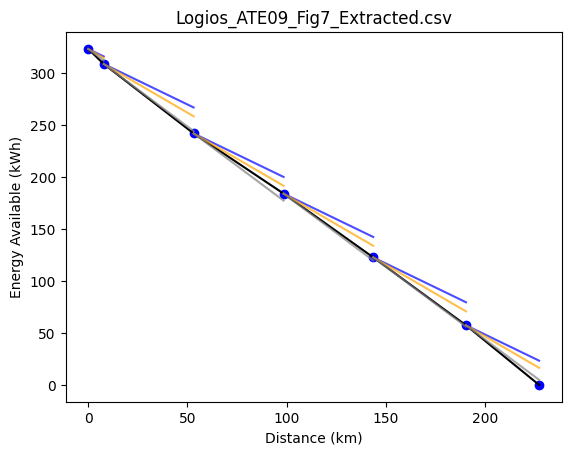

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   0.0 km.  dist: 7.8 km.  energy: -14.5 kWh
[Segment 2] start:   7.8 km.  dist: 45.3 km.  energy: -66.9 kWh
[Segment 3] start:  53.1 km.  dist: 45.3 km.  energy: -57.9 kWh
[Segment 4] start:  98.4 km.  dist: 45.2 km.  energy: -61.4 kWh
[Segment 5] start: 143.6 km.  dist: 46.7 km.  energy: -65.4 kWh
[Segment 6] start: 190.3 km.  dist: 36.8 km.  energy: -57.4 kWh


In [14]:
disc_consump_file = 'Logios_ATE09_Fig5_Extracted.csv'
energy_avail_file = 'Logios_ATE09_Fig7_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

# TODO: Do this comparison for the final route.

These comparisons of graphs for AB03 and TC08 hint that Logios may have mislabeled their 'Energy Available' graphs (e.g. Figures 4 and 13). 

- For AB03 and TC08: Though they label them as illustrating the energy consumption with passengers and HVAC, it looks more like they do not include the HVAC consumption. 
- For AT09: It looks like Fig 7 actually DOES show what it is labeled as, the energy burndown rate assuming base, passengers, and HVAC load. 